# Starting with MAB

In this notebook, we use SMPyBandits as the base library for MAB implementartion.

In [1]:
# Dépendances
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from SMPyBandits.Environment import MAB

#Arms
from SMPyBandits.Arms import Bernoulli
from SMPyBandits.Arms import Gaussian
from SMPyBandits.Arms import Constant

#Policies
from SMPyBandits.Policies import Uniform
from SMPyBandits.Policies import EmpiricalMeans
from SMPyBandits.Policies import EpsilonGreedy
from SMPyBandits.Policies import UCBalpha
from SMPyBandits.Policies import klUCB
from SMPyBandits.Policies import Thompson
from SMPyBandits.Policies import SoftMix

#Plot
from mabplot import plot_progression, plot_hist_regret, plot_comp, plot_freq

#Sim
from mabsim import simulate, cumulative_sum, progressive_average, average, window_average, cumulative_regret, actions_map, actions_count, actions_freq, star_freq

#Averaging
from mabavg import prog_avg, win_avg

#print or not
verbose = False


if verbose:
    
    import SMPyBandits.Policies
    import inspect
    
    print("ALGS:")
    for name, obj in inspect.getmembers(SMPyBandits.Policies):
        if inspect.isclass(obj) and not inspect.isabstract(obj):
            print(name)
    print("ARMS:")
    for name, obj in inspect.getmembers(SMPyBandits.Arms):
        if inspect.isclass(obj) and not inspect.isabstract(obj):
            print(name)


Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...


In [2]:
#MAB parameters
means = np.array([0.1, 0.6, 0.7, 0.9, 0.91])
k = len(means)
K = np.arange(k)   #range for arms
K1 = K+1           #range for arms (for labels, starting from 1)

#MAB properties
k_star = np.argmax(means)  # = 0
mean_star = np.max(means)

#arms objects
A = [Bernoulli(m) for m in means]

#MAB object
M = MAB(A)

#k = M.nbArms
#MG = MAB(Gaussian(m, sigma=0.05) for m in means)
#display(M.plotHistogram(horizon=10000))



Creating a new MAB problem ...
  Taking arms of this MAB problem from a list of arms 'configuration' = [B(0.1), B(0.6), B(0.7), B(0.9), B(0.91)] ...
 - with 'arms' = [B(0.1), B(0.6), B(0.7), B(0.9), B(0.91)]
 - with 'means' = [0.1  0.6  0.7  0.9  0.91]
 - with 'nbArms' = 5
 - with 'maxArm' = 0.91
 - with 'minArm' = 0.1

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 19.4 ... 
 - a Optimal Arm Identification factor H_OI(mu) = 53.20% ...
 - with 'arms' represented as: $[B(0.1), B(0.6), B(0.7), B(0.9), B(0.91)^*]$


Then we can generate some draws, from all arms, from time $t=1$ to $t=T_0$, for let say $T_0 = 1000$ :

In [3]:
n = 1000  #time-horizon
T = np.arange(n)       #range for time
T1 = T+1               #range for time (for labels, starting from 1)

#Rewards for every arm in the given horizon
draws = M.draw_each_nparray(shape=(n,))
if verbose:
    display(pd.DataFrame(draws, columns=T1, index=K1))

In [16]:
#algorithms
G = [
     {'obj':EpsilonGreedy(k, epsilon=0.1),'name':"Eps(0.9)" , 'line':"-." },
     {'obj':SoftMix(k),'name':"SoftMix" , 'line':"-." },
     {'obj':EmpiricalMeans(k),'name':"MoyenneEmpirique" , 'line':":" },
     {'obj':UCBalpha(k, alpha=4),'name':"UCB1(alpha=4)" , 'line':"-" },
     {'obj':UCBalpha(k, alpha=1),'name':"UCB1(alpha=1)" , 'line':"-" },
     {'obj':UCBalpha(k, alpha=0.5),'name':"UCB1(alpha=0.5)" , 'line':"-" },
     {'obj':klUCB(k),'name':"KLUCB" , 'line':"-." },
     {'obj':Thompson(k),'name':"ThompsonSampling" , 'line':"--" }
]

G_name = [g['name'] for g in G]
G_obj = [g['obj'] for g in G]
G_line = [g['line'] for g in G]

import ipywidgets as widgets
from ipywidgets import interact_manual, interactive, fixed

wg_N = widgets.FloatLogSlider(
    value=1000,
    base=10,
    min=1, # max exponent of base
    max=5, # min exponent of base
    step=1, # exponent step
    description='time-horizon ($n$)',
    readout_format='d'
)

wg_rep = widgets.FloatLogSlider(
    value=10,
    base=10,
    min=0, # max exponent of base
    max=4, # min exponent of base
    step=1, # exponent step
    description='repetitions ($m$)',
    readout_format='d'
)

def run(plt, g, horizon, repetitions):

    n = int(horizon)  #time-horizon
    T = np.arange(n)       #range for time
    T1 = T+1               #range for time (for labels, starting from 1)

    m = int(repetitions)  #simulation repetitions
    
    #Rewards and Actions History
    R, H = simulate(A, g, n)
    H1 = H+1

    if verbose:
        print("H:")
        print(H)

    if (n<=100):
        mark = 'o'
    else:
        mark = '.'
        
    plt.plot(T1, H1, mark)

    plt.yticks(K1)

    plt.xlabel('$t$')
    plt.ylabel('Arm')
    plt.gca().invert_yaxis()    
    plt.title('History of pulled arms')

    plt.show()
    
    return R, H, g, n, T, T1, H1, m

widget = interactive(run, {'manual' : True, 'manual_name' : 'Run Simulation'}, plt=fixed(plt), g=G_obj, horizon=wg_N, repetitions=wg_rep)
display(widget)

#xxx = interact_manual(run, plt=fixed(plt), algorithm=G, horizon=wg_N);

interactive(children=(Dropdown(description='g', options=(<SMPyBandits.Policies.EpsilonGreedy.EpsilonGreedy obj…

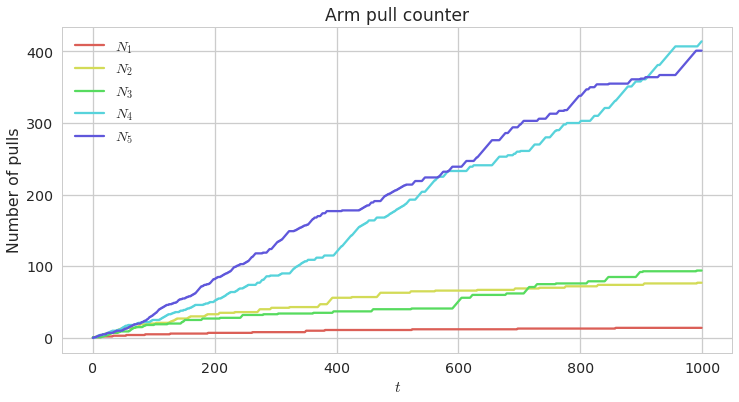

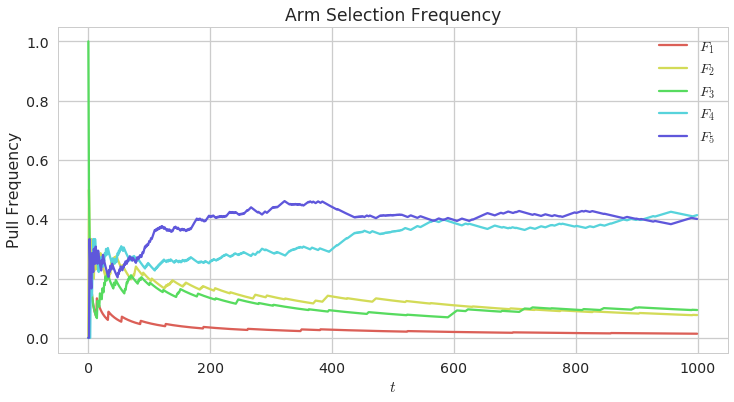

In [26]:
R, H, g, n, T, T1, H1, m = widget.result

H_a = actions_map(k, H)
N_a = actions_count(k, H)
F_a = actions_freq(k, H)

plt.figure(figsize=(12, 6))
plot_progression(N_a, names=[f"$N_{i+1}$" for i in K], title="Arm pull counter", ylabel="Number of pulls")
plt.show()

plt.figure(figsize=(12, 6))
plot_progression(F_a, names=[f"$F_{i+1}$" for i in K], title="Arm Selection Frequency", ylabel="Pull Frequency")
plt.show()

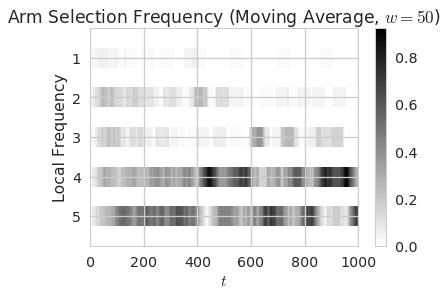

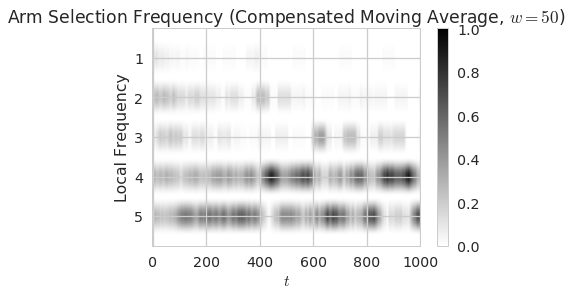

In [27]:
w=min(50, n//5)

FWA_a = np.array([window_average(H_a[i], w) for i in K])
FWC_a = np.array([window_average(H_a[i], w, compensate=True) for i in K])
#FWA_a = window_average(H, w)
#FWC_a = window_average(H_a, w, compensate=True)

plot_freq(FWA_a, interpolation='none')

plt.xlabel('$t$')
plt.ylabel('Local Frequency')
plt.title(f"Arm Selection Frequency (Moving Average, $w={w}$)")

plt.colorbar()
plt.show()

plot_freq(FWC_a)

plt.xlabel('$t$')
plt.ylabel('Local Frequency')
plt.title(f"Arm Selection Frequency (Compensated Moving Average, $w={w}$)")

plt.colorbar()
plt.show()

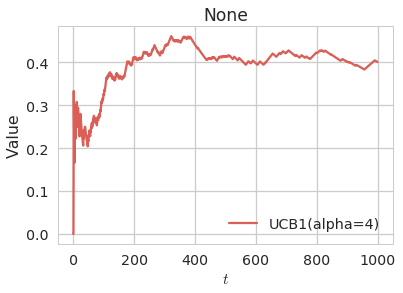

In [28]:
names = [G_name[G_obj.index(g)]]
lines = [G_line[G_obj.index(g)]]

plot_progression(F_a[k_star], names, lines)

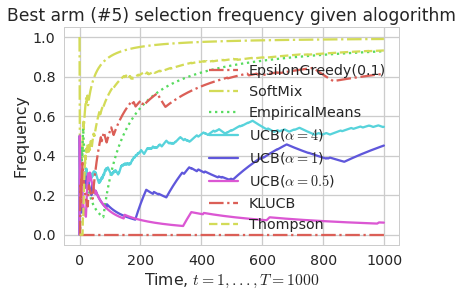

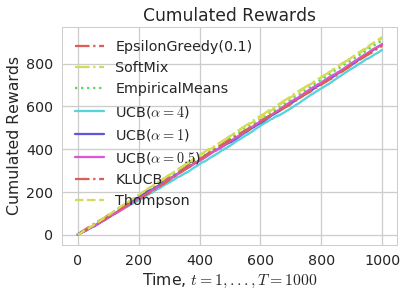

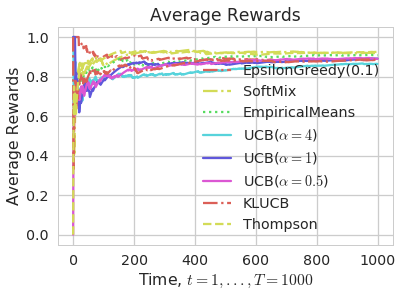

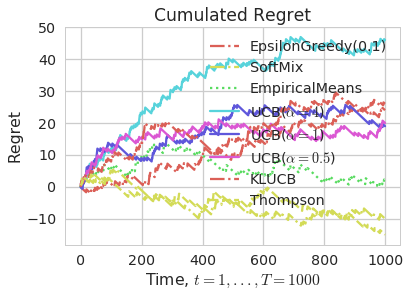

In [16]:
R_g, A_g = simulate(A, G_obj, n)

#names = [G_name[i] for i in range(len(G))]
names = [str(g) for g in G_obj]
lines = [G_line[i] for i in range(len(G))]

if verbose:
    print(A_g)
    print(R_g)

plot_selections(A_g, names, lines, k_star)

plot_reward_sum(R_g, names, lines)

plot_avg_reward(R_g, names, lines)

plot_regret(R_g, names, lines, mustar=mean_star)

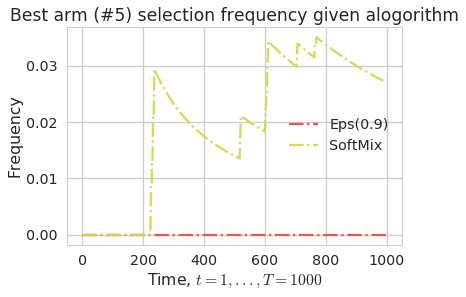

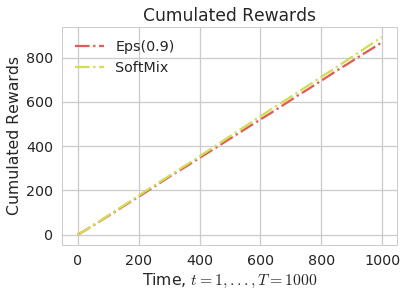

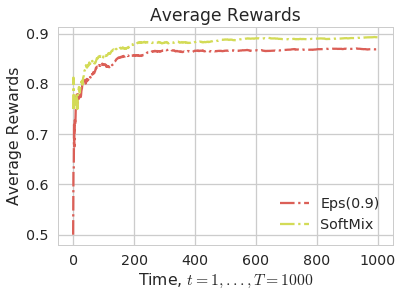

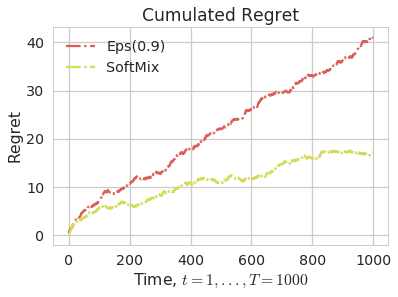

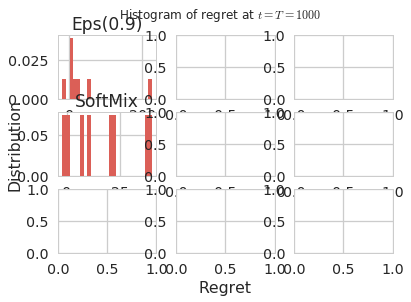

ValueError: shape mismatch: objects cannot be broadcast to a single shape

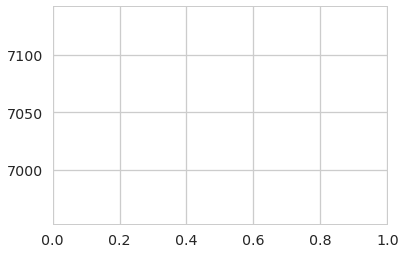

In [17]:
repetitions = 2

R_g, A_g = simulate(A, G_obj, n, repetitions)

avg_rewards = np.mean(R_g, axis=1)
avg_actions = np.mean(A_g, axis=1)

acc_rewards = np.sum(R_g, axis=2)
acc_actions = np.sum(A_g, axis=2)

avg_acc_rewards = np.sum(acc_rewards, axis=1)
avg_acc_actions = np.sum(acc_actions, axis=1)

plot_selections(avg_actions, G_name, G_line, k_star)

plot_reward_sum(avg_rewards, G_name, G_line)

plot_avg_reward(avg_rewards, G_name, G_line)

plot_regret(avg_rewards, G_name, G_line, mustar=mean_star)

plot_hist_regret(acc_rewards, G_name, n, mustar=mean_star)

plot_comp(avg_acc_rewards, G_name)

In [6]:
import numpy as np
x = np.array([10, 1000, 200])
idx = np.argsort([10, 1000, 200])
print(x[idx])

[  10  200 1000]
